In [48]:
import tensorflow as tf
import numpy as np

In [49]:
from tensorflow import keras

model_location='/home/craig/Documents/YOLO-3-OpenCV/yolo3_tf/yolov3_model'
yolo3_model=keras.models.load_model(model_location,compile=False)

In [53]:
layer=yolo3_model.get_layer('conv_0')
feature_extractor=tf.keras.Model(inputs=yolo3_model.inputs,outputs=layer.output)


In [64]:
layer.weights[0]
wts=tf.transpose(layer.weights[0],perm=[3,0,1,2])
#tf.shape(new_wts)
wts.numpy()

array([[[[-7.39838630e-02, -4.35802005e-02,  2.63345968e-02],
         [ 1.79278374e-01, -1.08121470e-01,  1.10361390e-01],
         [-3.00073363e-02, -2.76579820e-02, -7.16836452e-02]],

        [[ 9.11507085e-02,  3.74525450e-02,  6.07688501e-02],
         [-1.68761816e-02, -1.49165183e-01,  5.06702401e-02],
         [ 9.80103165e-02,  6.87774867e-02,  3.66386212e-02]],

        [[ 2.71728705e-03,  4.02355902e-02, -7.10724574e-03],
         [-7.27469146e-01, -4.11971033e-01, -4.44822967e-01],
         [ 2.75320895e-02,  6.21622801e-02,  1.44725703e-02]]],


       [[[-1.65614009e-01, -1.81117013e-01, -2.10971773e-01],
         [-1.39581084e-01, -1.55092314e-01, -1.75061151e-01],
         [-7.55509213e-02,  1.05160356e-01,  3.37304771e-02]],

        [[-2.65302099e-02, -3.05253938e-02, -9.25346464e-02],
         [-2.58116961e-01, -2.60974079e-01, -2.42266491e-01],
         [-2.65929028e-02,  6.87906742e-02,  1.07290685e-01]],

        [[-2.87525505e-02,  4.11110148e-02, -3.97543088e-0

In [65]:
tens=[]
for i in range(32):
    print(wts.numpy()[i])
    

[[[-0.07398386 -0.0435802   0.0263346 ]
  [ 0.17927837 -0.10812147  0.11036139]
  [-0.03000734 -0.02765798 -0.07168365]]

 [[ 0.09115071  0.03745255  0.06076885]
  [-0.01687618 -0.14916518  0.05067024]
  [ 0.09801032  0.06877749  0.03663862]]

 [[ 0.00271729  0.04023559 -0.00710725]
  [-0.72746915 -0.41197103 -0.44482297]
  [ 0.02753209  0.06216228  0.01447257]]]
[[[-0.16561401 -0.18111701 -0.21097177]
  [-0.13958108 -0.15509231 -0.17506115]
  [-0.07555092  0.10516036  0.03373048]]

 [[-0.02653021 -0.03052539 -0.09253465]
  [-0.25811696 -0.26097408 -0.24226649]
  [-0.0265929   0.06879067  0.10729069]]

 [[-0.02875255  0.04111101 -0.03975431]
  [ 0.03781441  0.08765321  0.01255679]
  [-0.05215133  0.00564741  0.02010574]]]
[[[ 0.09200411  0.1540454   0.09999298]
  [ 0.01070675  0.23836261  0.22160274]
  [-0.09049273  0.10741682  0.16180561]]

 [[-0.20219928 -0.18967193 -0.21416326]
  [-0.11879097  0.11737569  0.09505861]
  [-0.06624901  0.15239213  0.13041629]]

 [[-0.08976902 -0.275338

In [69]:
from IPython.display import Image

for i in range(32):
    img=wts.numpy()[i]
    name=str(i)+'.png'
    keras.preprocessing.image.save_img(name, img)
    Image(filename = name, width = 300, height = 300)


In [5]:
#from tensorflow import keras
#model_location='/home/craig/Documents/YOLO-3-OpenCV/yolo3_tf/yolov3_model'
#yolo3_model=keras.models.load_model(model_location)

In [79]:
from matplotlib import pyplot as plt
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.activation_maximization.input_modifiers import Jitter, Rotate2D
from tf_keras_vis.activation_maximization.regularizers import TotalVariation2D, Norm
from tf_keras_vis.utils.model_modifiers import ExtractIntermediateLayer, ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore , InactiveScore

In [5]:
def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

In [6]:
@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img

In [29]:
def initialize_image():
    # We start from a gray image with some random noise
    img = tf.random.uniform((1, img_width, img_height, 3))
    # ResNet50V2 expects inputs in the range [-1, +1].
    # Here we scale our random inputs to [-0.125, +0.125]
    return (img - 0.5) * 0.25


def visualize_filter(filter_index):
    # We run gradient ascent for 20 steps
    iterations = 100
    learning_rate = 10.0
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)
        

    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img


def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [12]:
img_width = 416
img_height = 416

In [28]:
loss, img = visualize_filter(16)

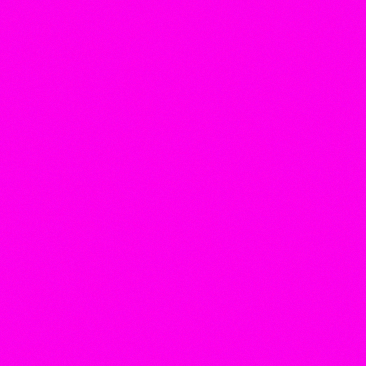

In [30]:
keras.preprocessing.image.save_img("0.png", img)
from IPython.display import Image
Image("0.png") 

In [31]:
all_imgs = []
for filter_index in range(32):
    print("Processing filter %d" % (filter_index,))
    loss, img = visualize_filter(filter_index)
    all_imgs.append(img)

# Build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between


Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15
Processing filter 16
Processing filter 17
Processing filter 18
Processing filter 19
Processing filter 20
Processing filter 21
Processing filter 22
Processing filter 23
Processing filter 24
Processing filter 25
Processing filter 26
Processing filter 27
Processing filter 28
Processing filter 29
Processing filter 30
Processing filter 31


IndexError: list index out of range

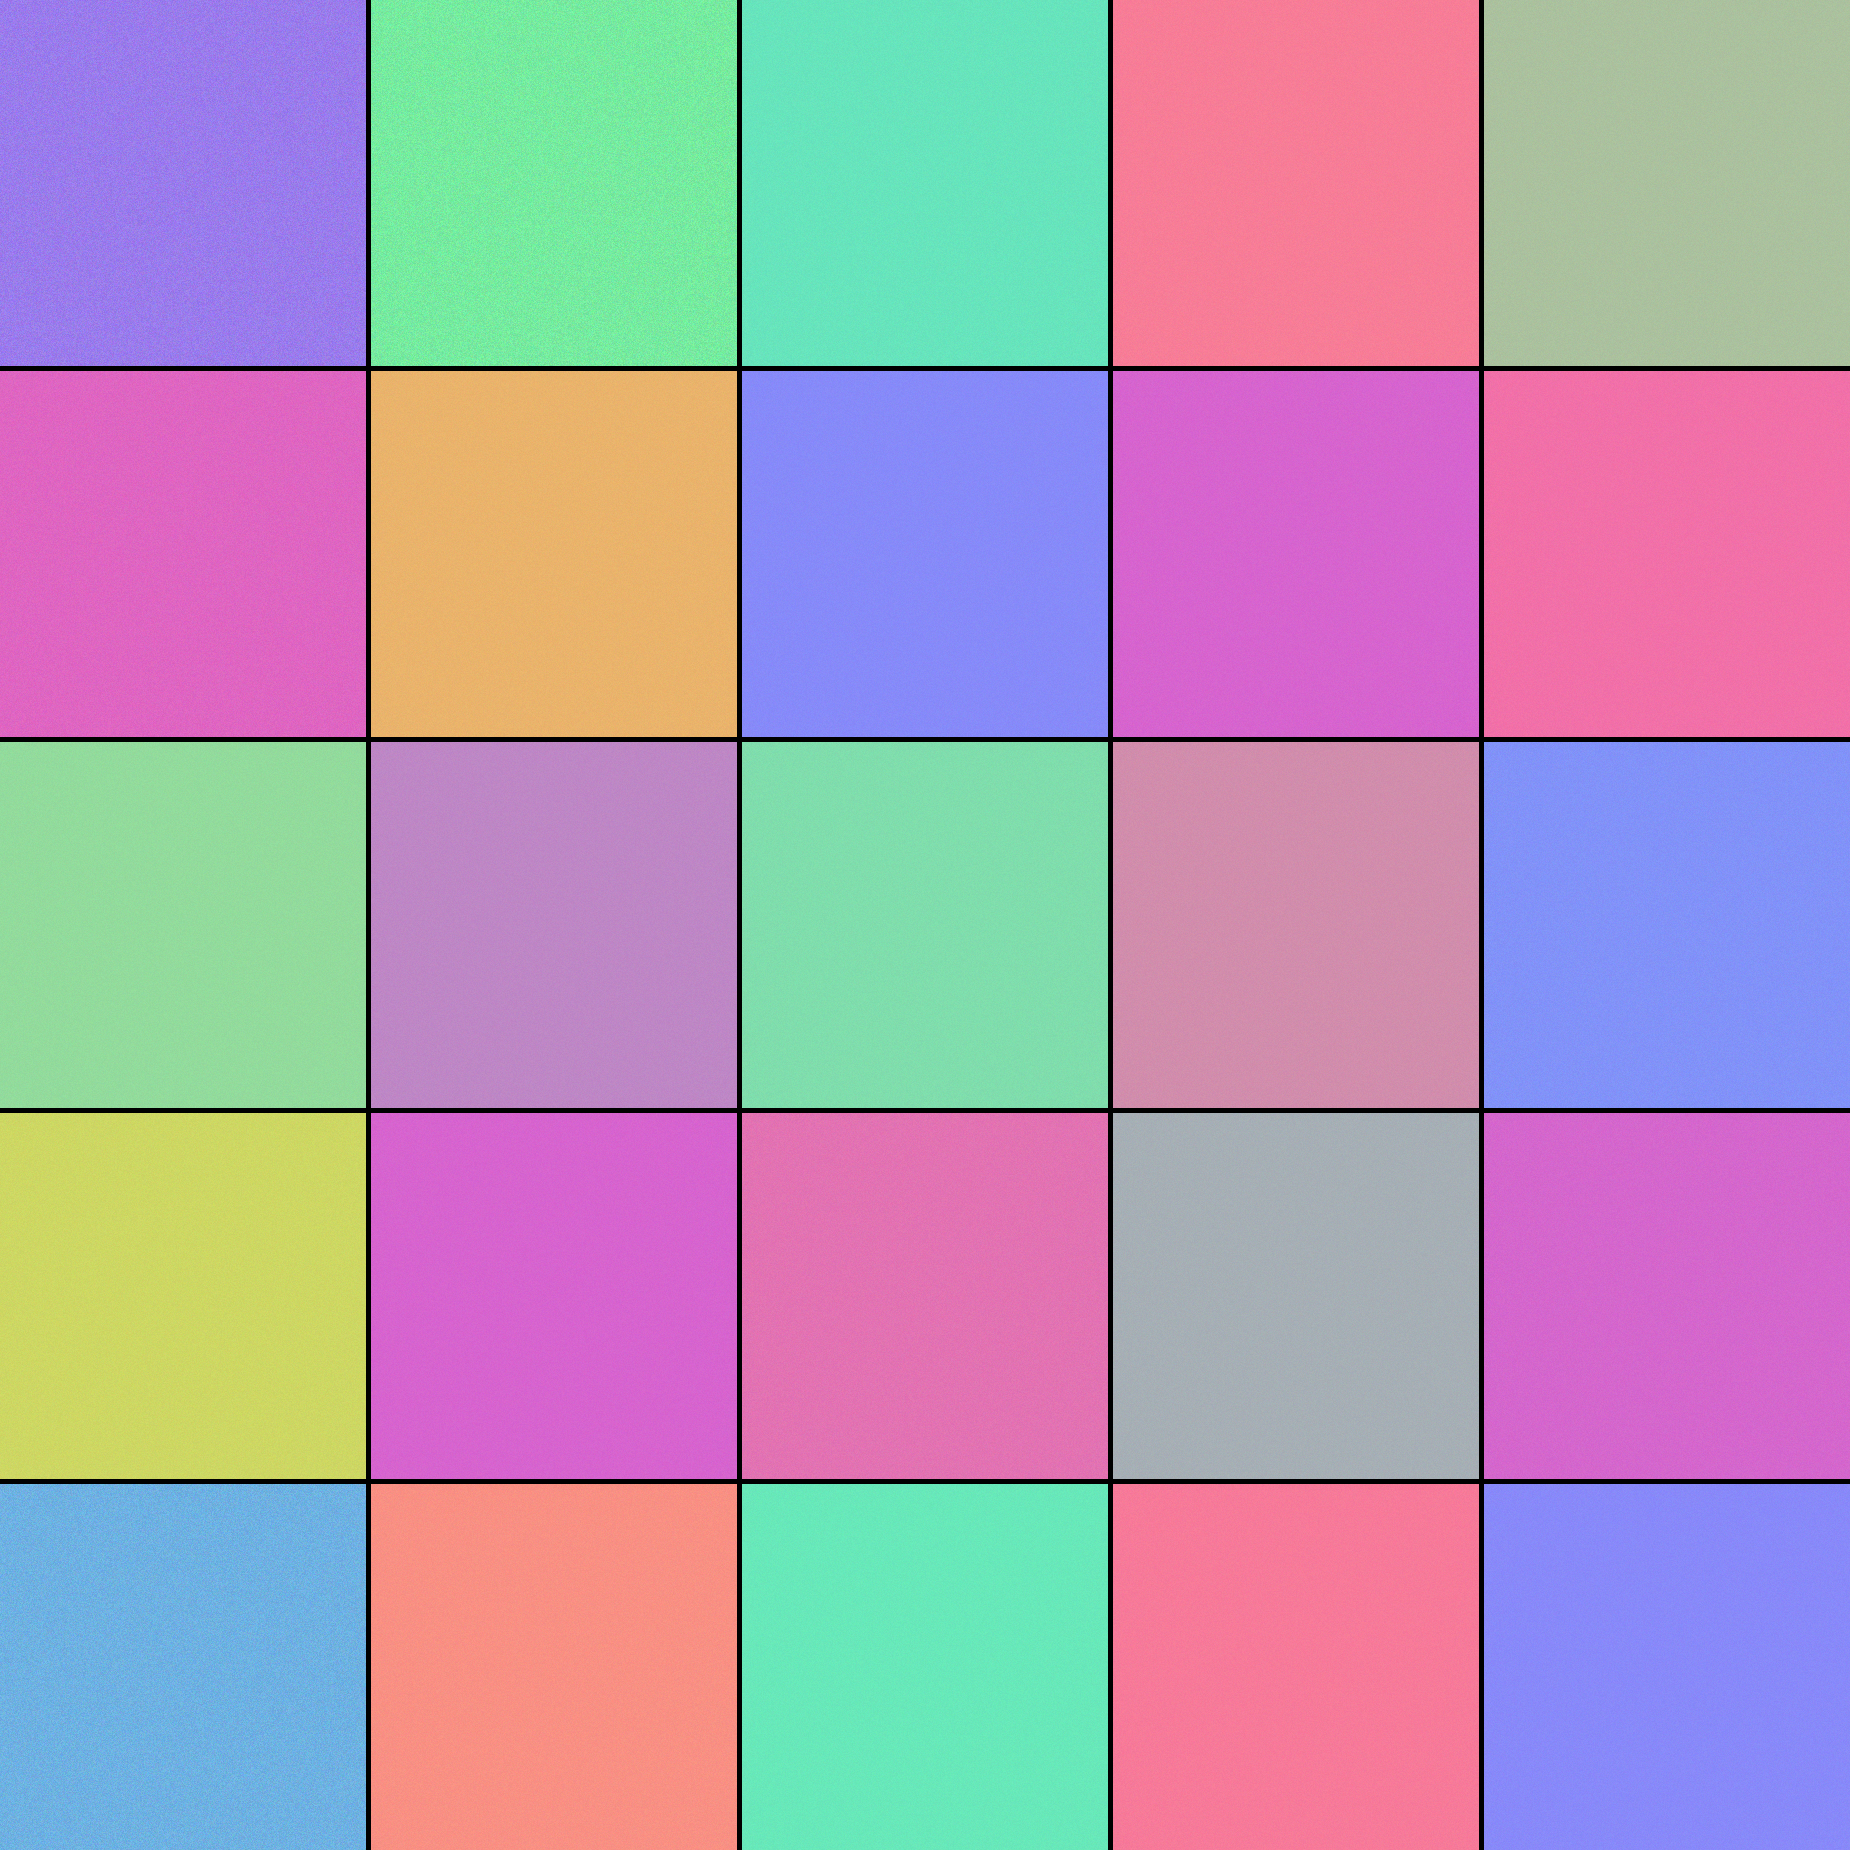

In [36]:
margin = 5
n = 5
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# Fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img = all_imgs[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = img
keras.preprocessing.image.save_img("stiched_filters.png", stitched_filters)

from IPython.display import Image, display

display(Image("stiched_filters.png"))

trying visualize dense layer

In [96]:
from tensorflow import keras
model_location='/home/craig/Documents/YOLO-3-OpenCV/yolo3_tf/yolov3_model'
yolo3_model=keras.models.load_model(model_location,compile=False)

In [97]:
car=2
replace2lin=ReplaceToLinear()
score=CategoricalScore(car)#,InactiveScore(), InactiveScore()]

In [98]:
activation_maximization =  ActivationMaximization(yolo3_model,
                          model_modifier=replace2lin,                       
                          clone=False)

In [101]:
FILTER_INDEX=1
a=activation_maximization(score,
                           steps=100,
                           input_modifiers=[Jitter(jitter=16), Rotate2D(degree=1)],
                           regularizers=[TotalVariation2D(weight=1.0),
                                         Norm(weight=0.3, p=1)],
                           optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.1),
                           callbacks=[Progress()])

100/100 [==============================] - 275s 3s/step - Score: 44.7951 - TotalVariation2D: 7.7185 - Norm: 38.2066


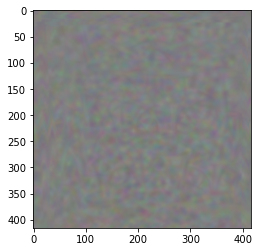

In [102]:
plt.imshow(a[0])

QObject::moveToThread: Current thread (0x55768589ff50) is not the object's thread (0x557665d93680).
Cannot move to target thread (0x55768589ff50)

QObject::moveToThread: Current thread (0x55768589ff50) is not the object's thread (0x557665d93680).
Cannot move to target thread (0x55768589ff50)

QObject::moveToThread: Current thread (0x55768589ff50) is not the object's thread (0x557665d93680).
Cannot move to target thread (0x55768589ff50)

QObject::moveToThread: Current thread (0x55768589ff50) is not the object's thread (0x557665d93680).
Cannot move to target thread (0x55768589ff50)

QObject::moveToThread: Current thread (0x55768589ff50) is not the object's thread (0x557665d93680).
Cannot move to target thread (0x55768589ff50)

QObject::moveToThread: Current thread (0x55768589ff50) is not the object's thread (0x557665d93680).
Cannot move to target thread (0x55768589ff50)

QObject::moveToThread: Current thread (0x55768589ff50) is not the object's thread (0x557665d93680).
Cannot move to tar

error: OpenCV(4.5.5) /io/opencv/modules/core/src/array.cpp:2494: error: (-206:Bad flag (parameter or structure field)) Unrecognized or unsupported array type in function 'cvGetMat'


TypeError: Invalid shape (1, 416, 416, 3) for image data

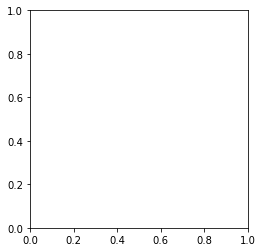

In [24]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 
#plt.matshow(a)

#plt.show()
#from matplotlib import pyplot as plt
plt.imshow(a, interpolation='nearest')
plt.show()

In [7]:
layer_name = 'conv_0' # The target layer that is the last layer of VGG16.

def model_modifier(current_model):
    target_layer = current_model.get_layer(name=layer_name)
    new_model = tf.keras.Model(inputs=current_model.inputs,
                               outputs=target_layer.output)
    new_model.layers[-1].activation = tf.keras.activations.linear
    return new_model

/tmp/ipykernel_19754/4165271906.py:8: DeprecationWarning: Call to deprecated class PrintLogger. (Use `Progress` instead.) -- Deprecated since version 0.7.0.
  callbacks=[Print(interval=50)])


Steps: 050	Scores: [[0.11236084997653961]],	Regularization: [('TotalVariation2D', [4.241844177246094]), ('Norm', [27.683664321899414])]
Steps: 100	Scores: [[0.199747234582901]],	Regularization: [('TotalVariation2D', [3.434602975845337]), ('Norm', [22.34778594970703])]
Steps: 150	Scores: [[0.2674337923526764]],	Regularization: [('TotalVariation2D', [2.59419846534729]), ('Norm', [18.18816566467285])]
Steps: 200	Scores: [[0.3255413770675659]],	Regularization: [('TotalVariation2D', [2.2413101196289062]), ('Norm', [14.632027626037598])]


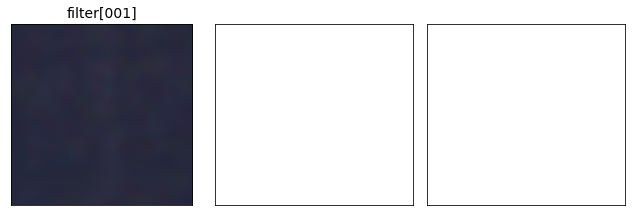

In [19]:
filter_numbers = [1]
from tf_keras_vis.activation_maximization import ActivationMaximization
activation_maximization = ActivationMaximization(yolo3_model, model_modifier, clone=False)
seed_input = tf.random.uniform((1, 416, 416, 3), 0, 255)
# Generate max activation
activations = activation_maximization(loss,
                                      seed_input=seed_input, # To generate multiple images
                                      callbacks=[Print(interval=50)])
images = [activation.astype(np.uint8) for activation in activations]

subplot_args = { 'nrows': 1, 'ncols': 3, 'figsize': (9, 3),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
f, ax = plt.subplots(**subplot_args)
for i, filter_number in enumerate(filter_numbers):
    ax[i].set_title('filter[{:03d}]'.format(filter_number), fontsize=14)
    ax[i].imshow(images[i])
    
plt.tight_layout()
plt.show()

In [9]:
filter_number = 7
def loss(output):
    return output[..., filter_number]

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


/tmp/ipykernel_19754/1708710221.py:5: DeprecationWarning: Call to deprecated class PrintLogger. (Use `Progress` instead.) -- Deprecated since version 0.7.0.
  activation = activation_maximization(loss, callbacks=[Print(interval=50)])


Steps: 050	Scores: [[0.11235189437866211]],	Regularization: [('TotalVariation2D', [4.279479026794434]), ('Norm', [27.41758155822754])]
Steps: 100	Scores: [[0.20039024949073792]],	Regularization: [('TotalVariation2D', [2.8939502239227295]), ('Norm', [22.04347801208496])]
Steps: 150	Scores: [[0.26854029297828674]],	Regularization: [('TotalVariation2D', [2.772125720977783]), ('Norm', [17.873613357543945])]
Steps: 200	Scores: [[0.32683706283569336]],	Regularization: [('TotalVariation2D', [4.257735252380371]), ('Norm', [14.314007759094238])]


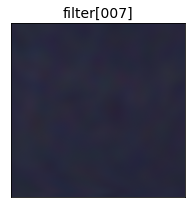

In [10]:
%time
from tf_keras_vis.utils.callbacks import Print

# Generate max activation
activation = activation_maximization(loss, callbacks=[Print(interval=50)])
image = activation[0].astype(np.uint8)

# Render
subplot_args = { 'nrows': 1, 'ncols': 1, 'figsize': (3, 3),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
                 
f, ax = plt.subplots(**subplot_args)
ax.imshow(image)
ax.set_title('filter[{:03d}]'.format(filter_number), fontsize=14)
plt.tight_layout()
plt.show()

In [8]:
filter_numbers = [63, 132, 320]

# Define loss function that returns multiple filter outputs.
def loss(output):
    return (output[0, ..., 63], output[1, ..., 132], output[2, ..., 320])

In [9]:
# Define seed inputs whose shape is (samples, height, width, channels).

seed_input = tf.random.uniform((3, 224, 224, 3), 0, 255)


/tmp/ipykernel_19754/3409572289.py:4: DeprecationWarning: Call to deprecated class PrintLogger. (Use `Progress` instead.) -- Deprecated since version 0.7.0.
  callbacks=[Print(interval=50)])


Steps: 050	Scores: [[0.11008691787719727]],	Regularization: [('TotalVariation2D', [4.3413519859313965]), ('Norm', [27.59743309020996])]
Steps: 100	Scores: [[0.19739611446857452]],	Regularization: [('TotalVariation2D', [3.073486328125]), ('Norm', [22.256980895996094])]
Steps: 150	Scores: [[0.26544660329818726]],	Regularization: [('TotalVariation2D', [2.7546210289001465]), ('Norm', [18.102176666259766])]
Steps: 200	Scores: [[0.3235452175140381]],	Regularization: [('TotalVariation2D', [2.4413058757781982]), ('Norm', [14.54624080657959])]


NameError: name 'filter_numbers' is not defined

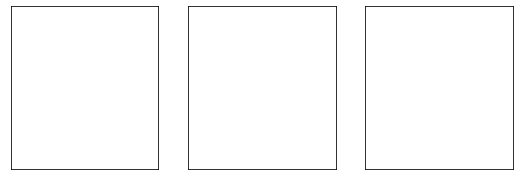

In [17]:
# Generate max activation
activations = activation_maximization(loss,
                                      seed_input=seed_input, # To generate multiple images
                                      callbacks=[Print(interval=50)])
images = [activation.astype(np.uint8) for activation in activations]

# Render
subplot_args = { 'nrows': 1, 'ncols': 3, 'figsize': (9, 3),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
f, ax = plt.subplots(**subplot_args)
for i, filter_number in enumerate(filter_numbers):
    ax[i].set_title('filter[{:03d}]'.format(filter_number), fontsize=14)
    ax[i].imshow(images[i])
    
plt.tight_layout()
plt.show()